In [1]:
from datetime import datetime

import cartopy.crs as ccrs # type: ignore
import geopandas as gpd # type: ignore
import matplotlib.pyplot as plt # type: ignore
import numpy as np # type: ignore
import xarray as xa # type: ignore
from shapely import LineString # type: ignore

proj_nps = ccrs.NorthPolarStereo()
proj_pc = ccrs.PlateCarree()

In [2]:
# load polygins with S1 border created in "get_nc_geolocations.ipynb"
s1_polygons_file = '/Data/sat/downloads/sentinel1/apasip/202001/polygons'
s1gdf = gpd.GeoDataFrame.from_file(s1_polygons_file)

# regenerate the index with dates from S1 names
s1dates = [datetime.strptime(n.split('_')[4], '%Y%m%dT%H%M%S') for n in s1gdf['names']]
s1gdf.index = s1dates

In [4]:
# load dataframe with CS2 L2 LARM data
ifile = '/Data/sat/downloads/CS2/LARM2/uit_cryosat2_L2_alongtrack_2020_01.nc'
with xa.open_dataset(ifile) as ds:
    df = ds.to_dataframe()

# create geopandas GeoDataframe with orbits as geometries
orbits = []
dates = []
orbit_nos = []
for orbit_no in df['orbit_no'].unique():
    subdf = df[(df['orbit_no'] == orbit_no)]
    x, y, _ = proj_nps.transform_points(proj_pc, subdf['Longitude'], subdf['Latitude']).T
    orbits.append(LineString(zip(x, y)))
    dates.append(subdf.index[0])
    orbit_nos.append(int(orbit_no))

cs2gdf = gpd.GeoDataFrame(dict(orbit_no=orbit_nos, geometry=orbits), index=dates)

In [5]:
# find interesction of ALL cs2 with ALL s1
join = gpd.sjoin(left_df=cs2gdf, right_df=s1gdf, how="left", predicate="intersects")
print(join.shape, join.columns)

(238681, 5) Index(['orbit_no', 'geometry', 'index_right0', 'index', 'names'], dtype='object')


92


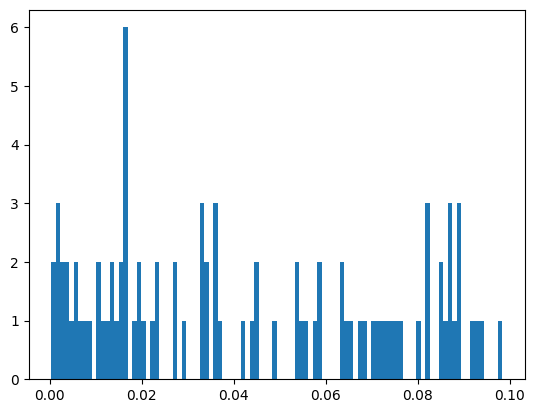

In [6]:
# compute time difference between all S1 and all CS2 intersections
time_diffs = []
for j0, j1 in zip(join.index, join.index_right0):
    time_diffs.append(np.abs((j0 - j1).total_seconds()) / 3600)
time_diffs = np.array(time_diffs)

# find intersections that have max 0.1 hours between
# plot historgram of time between intersections
max_time_dif = 0.1
small_time_diff_idx = np.nonzero(time_diffs < max_time_dif)[0]
_ = plt.hist(time_diffs[small_time_diff_idx], 100)
print(small_time_diff_idx.size)

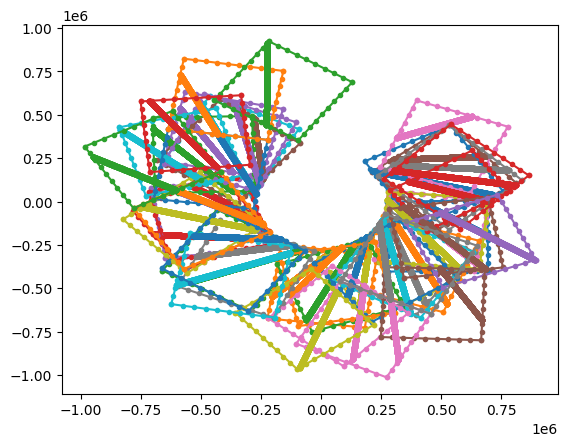

44


In [7]:
# find intersections that have min 1000 CS2 points
min_jg_size = 1000

small_time_diff_large_size_idx = []
for i in small_time_diff_idx:
    cs2i = join.index[i]
    s1i = join.index_right0.iloc[i]
    cs2g = cs2gdf.geometry[cs2i]
    s1g = s1gdf.geometry[s1i]
    jg = cs2g.intersection(s1g)
    jg_size = np.array(jg.coords.xy[0]).size
    if jg_size > min_jg_size:
        small_time_diff_large_size_idx.append(i)
        l0 = plt.plot(*np.stack(jg.coords).T, '.')
        plt.plot(*np.stack(s1g.exterior.coords).T, '.-', color=l0[0].get_color())
plt.show()
print(len(small_time_diff_large_size_idx))

In [8]:
# save information about intersections in pandas datafarme pickle
intersect_df = join.iloc[np.array(small_time_diff_large_size_idx)][['orbit_no', 'index_right0', 'names']]
intersect_df.to_pickle(f'{s1_polygons_file}/intersect.pickle')